# Investigating Pseudo-labeling Performance Sans Supporting Algorithms and Models

---

> Dimitris Tsirmpas <br>
> MSc in Data Science f3352315 <br>
> Athens University of Economics and Business

## Directory Structure

The project is structured as follows:

Main files:
- domain_adaptation.ipynb: is the main Jupyter Notebook containing the project code
- report.pdf: Supplemental material containing Figures, Tables and analysis on the results of the project
  
Directories:
- lib: a library of general functions for Data Science tasks
- tasks: task-specific modules
- data: the input data
- output: the model training output
- results: Graphs, Tables and Figures produced in the project
- scripts: pre-processing scripts applied to the data

Notes:

* This notebook mainly discusses the implementation and design decisions of the project. For the theory, experimental procedures
and results, consult [the main report](report.pdf).

* This notebook does not contain the fundamental code for preprocessing, loading data, training models, implementing the pseudo-labeling procedure
or our incremental learning algorithm. The code, as well as extensive comments and documentation, exist in the respective source files in the
`tasks` and `lib` directories.

## Modern Office Dataset

In [1]:
%load_ext autoreload
%autoreload 2

import lib.data
import lib.torch_train_eval
import lib.adaptive_train_eval
import lib.coral_train

import tasks.preprocessing
import tasks.utils
import tasks.results

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

import random
import os


DATA_DIR = "data/office"
OUTPUT_DIR = "output/office"
RESULTS_DIR = "results"

RANDOM_SEED = 42
BATCH_SIZE = 1
PRINT_STATS_PERIOD = 500

SOURCE_DATASET = "amazon"
SOURCE_VAL_SPLIT = .15
SOURCE_TEST_SPLIT = .1

TARGET_VAL_SPLIT = .15
TARGET_TEST_SPLIT = .15
TARGET_DATASET = "webcam"

RHO = 4
SAMPLING_PERIOD = 20

FINETUNED_SOURCE__MODEL_DIR = os.path.join(OUTPUT_DIR, "classifier")
CORAL_SOURCE_MODEL_DIR = os.path.join(OUTPUT_DIR, "coral")
FINETUNED_TARGET_MODEL_DIR = os.path.join(OUTPUT_DIR, "target_classifier")
UNSUPERVISED_MODEL_DIR = os.path.join(OUTPUT_DIR, "unsupervised")
SEMI_SUPERVISED_FINETUNED_MODEL_DIR_20 = os.path.join(OUTPUT_DIR, "semi-supervised-finetuned-20")
SEMI_SUPERVISED_ADAPTIVE_MODEL_DIR_20 = os.path.join(OUTPUT_DIR, "semi-supervised-adaptive-20")
SEMI_SUPERVISED_FINETUNED_MODEL_DIR_10 = os.path.join(OUTPUT_DIR, "semi-supervised-finetuned-10")
SEMI_SUPERVISED_ADAPTIVE_MODEL_DIR_10 = os.path.join(OUTPUT_DIR, "semi-supervised-adaptive-10")

FINETUNE_SOURCE_MODEL = False
TRAIN_CORAL_MODEL = False
FINETUNE_TARGET_MODEL = False
TRAIN_UNSUPERVISED_MODEL = False
FINETUNE_SEMI_SUPERVISED_MODEL_20 = False
TRAIN_SEMI_SUPERVISED_MODEL_20 = False
FINETUNE_SEMI_SUPERVISED_MODEL_10 = False
TRAIN_SEMI_SUPERVISED_MODEL_10 = False

random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


### Dataset preprocessing

Most of the work here is done through the ImageDataset class, which lazy loads all images from the given root directory. 

We import the data from the source dataset (Modern Office-31 Amazon domain)...

In [ ]:
source_dataset = lib.data.ImageDataset(
    parser_func=tasks.preprocessing.image_read_func,
    preprocessing_func=tasks.preprocessing.resnet_preprocessor,
)
source_dataset.load_from_directory(os.path.join(DATA_DIR, SOURCE_DATASET))

source_train_dataset, source_val_dataset, source_test_dataset = (
    lib.data.train_val_test_split(
        source_dataset, SOURCE_VAL_SPLIT, SOURCE_TEST_SPLIT
    )
)

source_train_loader = tasks.preprocessing.single_batch_loader(
    source_train_dataset, shuffle=True
)
source_val_loader = tasks.preprocessing.single_batch_loader(
    source_val_dataset, shuffle=False
)
source_test_loader = tasks.preprocessing.single_batch_loader(
    source_test_dataset, shuffle=False
)

... and the respective target dataset (Modern Office-31 Webcam domain).

In [ ]:
target_dataset = lib.data.ImageDataset(
    parser_func=tasks.preprocessing.image_read_func,
    preprocessing_func=tasks.preprocessing.resnet_preprocessor,
    label_encoder=source_dataset.label_encoder,  # use same classes
)
target_dataset.load_from_directory(os.path.join(DATA_DIR, TARGET_DATASET))

target_train_dataset, target_val_dataset, target_test_dataset = (
    lib.data.train_val_test_split(
        target_dataset, TARGET_VAL_SPLIT, TARGET_TEST_SPLIT
    )
)

target_train_loader = tasks.preprocessing.single_batch_loader(
    target_train_dataset, shuffle=True
)
target_val_loader = tasks.preprocessing.single_batch_loader(
    target_val_dataset, shuffle=False
)
target_test_loader = tasks.preprocessing.single_batch_loader(
    target_test_dataset, shuffle=False
)

We now import convert the target domain data into unlabelled and labelled datasets. 

We use a stratified split for all classes, converting 10%/20% of the target domain samples into labelled data and then adding them to the source domain dataset.

In [ ]:
unlabeled_dataset_20 = lib.data.UnlabeledImageDataset(
    parser_func=tasks.preprocessing.image_read_func,
    preprocessing_func=tasks.preprocessing.resnet_preprocessor,
)
unlabeled_dataset_20.load_from_image_dataset(target_train_dataset)

to_be_unlabeled_dataset_20, labeled_dataset_20 = lib.data.stratified_split(
    target_train_dataset, test_size=0.2
)

unlabeled_dataset_20 = lib.data.UnlabeledImageDataset(
    parser_func=labeled_dataset_20.parser_func,
    preprocessing_func=labeled_dataset_20.preprocessing_func,
)
unlabeled_dataset_20.load_from_image_dataset(to_be_unlabeled_dataset_20)

# combine data from both domain and target datasets
for sample_img, sample_label in source_train_dataset.samples:
    labeled_dataset_20.add(sample_img, sample_label)

len(labeled_dataset_20), len(source_train_dataset)

In [ ]:
to_be_unlabeled_dataset_10, labeled_dataset_10 = lib.data.stratified_split(
    target_train_dataset, test_size=0.1
)

unlabeled_dataset_10 = lib.data.UnlabeledImageDataset(
    parser_func=labeled_dataset_10.parser_func,
    preprocessing_func=labeled_dataset_20.preprocessing_func,
)
unlabeled_dataset_10.load_from_image_dataset(to_be_unlabeled_dataset_10)

# combine data from both domain and target datasets
for sample_img, sample_label in source_train_dataset.samples:
    labeled_dataset_10.add(sample_img, sample_label)

len(labeled_dataset_10), len(source_train_dataset)

In [ ]:
class_names = source_train_dataset.label_encoder.classes_

office_encodings = {
    label: class_name
    for label, class_name in enumerate(source_train_dataset.label_encoder.classes_)
}

### Source-only model

We will be using the ResNet-18 model, pre-trained on the ImageNet dataset. 

From our experience, keeping the pre-trained classification head of 1000 classes actually significantly speeds up training and avoids overfitting. Thus, we do not replace it with our own 31-class dense layer.

In [ ]:
import torchinfo


#https://arxiv.org/pdf/2405.13698
# disable lr for adam
exp_lr_scheduler = None

torchinfo.summary(tasks.utils.get_model(device=device), input_size=(BATCH_SIZE, 3, 1500, 1500))

We finetune the pretrained model on the source domain dataset (Amazon domain):

In [ ]:
model = tasks.utils.get_model(device=device)

if FINETUNE_SOURCE_MODEL:
    criterion = nn.CrossEntropyLoss(label_smoothing=0.05)
    model = tasks.utils.try_load_weights(model, os.path.join(FINETUNED_SOURCE__MODEL_DIR, "model.pt"))
    optimizer_ft = optim.Adam(model.parameters())

    history = tasks.utils.try_load_history(os.path.join(FINETUNED_SOURCE__MODEL_DIR, "history.pickle"))
    model, history = lib.torch_train_eval.train_model(
        model,
        criterion,
        optimizer_ft,
        exp_lr_scheduler,
        device,
        source_train_loader,
        source_val_loader,
        output_dir=FINETUNED_SOURCE__MODEL_DIR,
        num_epochs=50,
        patience=5,
        warmup_period=5,
        gradient_accumulation=1,
        previous_history=history,
        train_stats_period=PRINT_STATS_PERIOD
    )
else:
    history = tasks.utils.try_load_history(os.path.join(FINETUNED_SOURCE__MODEL_DIR, "history.pickle"))
    model = tasks.utils.try_load_weights(model, os.path.join(FINETUNED_SOURCE__MODEL_DIR, "model.pt"))

And print the learning curves as well as the classification results on both source and target domain test sets:

In [ ]:
tasks.results.learning_curves_loss(history)
tasks.results.learning_curves_accuracy(history)

In [ ]:
tasks.results.classification_results(model, source_test_loader, class_names, device)

In [ ]:
tasks.results.classification_results(model, target_test_loader, class_names, device)

We can clearly see that our baseline, the source-only model, can not effectively distinguish between any of the classes (except for the first few).

### Target only model

The procedure described above is repeated for the model trained on the target domain.

In [ ]:
model = tasks.utils.get_model(device=device, replace_fc_layer=True, num_classes=len(office_encodings))

if FINETUNE_TARGET_MODEL:
    criterion = nn.CrossEntropyLoss(label_smoothing=0.05)
    model = tasks.utils.try_load_weights(model, os.path.join(FINETUNED_TARGET_MODEL_DIR, "model.pt"))
    optimizer_ft = optim.AdamW(model.parameters(), weight_decay=10e-2)

    history = tasks.utils.try_load_history(os.path.join(FINETUNED_TARGET_MODEL_DIR, "history.pickle"))
    model, history = lib.torch_train_eval.train_model(
        model,
        criterion,
        optimizer_ft,
        exp_lr_scheduler,
        device,
        target_train_loader,
        target_val_loader,
        output_dir=FINETUNED_TARGET_MODEL_DIR,
        num_epochs=100,
        patience=10,
        warmup_period=25,
        gradient_accumulation=1,
        previous_history=history,
        train_stats_period=20000,
        verbose=False
    )
else:
    history = tasks.utils.try_load_history(os.path.join(FINETUNED_TARGET_MODEL_DIR, "history.pickle"))
    model = tasks.utils.try_load_weights(model, os.path.join(FINETUNED_TARGET_MODEL_DIR, "model.pt"))

In [ ]:
tasks.results.learning_curves_loss(history)
tasks.results.learning_curves_accuracy(history)

In [ ]:
tasks.results.classification_results(model, target_test_loader, class_names, device)

Surprisingly, there is no way we can effectively train the target-only model which was supposed to be our baseline. 
Due to the low number of datapoints and the difficulty of the domain, it immediately overfits. No amount of increasing regularization
(such as AdamW with weight_decay=$10^{-2}$) seems to influence the results. Additionally, we can not use data augmentation, since that
would make the comparison between models unfair.

### CORAL Source model

In [ ]:
model = tasks.utils.get_model(device=device, replace_fc_layer=True, num_classes=len(office_encodings))

if TRAIN_CORAL_MODEL:
    criterion = nn.CrossEntropyLoss(label_smoothing=0.05)
    model = tasks.utils.try_load_weights(model, os.path.join(CORAL_SOURCE_MODEL_DIR, "model.pt"))
    optimizer_ft = optim.AdamW(model.parameters(), weight_decay=10e-2)

    history = tasks.utils.try_load_history(os.path.join(CORAL_SOURCE_MODEL_DIR, "history.pickle"))
    model, history = lib.coral_train.coral_train_model(
        model,
        criterion,
        optimizer_ft,
        exp_lr_scheduler,
        device,
        source_train_dataloader=source_train_loader,
        source_val_dataloader=source_val_loader,
        target_train_dataloader=target_train_loader,
        output_dir=CORAL_SOURCE_MODEL_DIR,
        num_epochs=50,
        patience=5,
        warmup_period=5,
        gradient_accumulation=1,
        previous_history=history,
        train_stats_period=PRINT_STATS_PERIOD,
        verbose=False
    )
else:
    history = tasks.utils.try_load_history(os.path.join(CORAL_SOURCE_MODEL_DIR, "history.pickle"))
    model = tasks.utils.try_load_weights(model, os.path.join(CORAL_SOURCE_MODEL_DIR, "model.pt"))

In [ ]:
tasks.results.learning_curves_loss(history)
tasks.results.learning_curves_accuracy(history)

In [ ]:
tasks.results.classification_results(model, source_test_loader, class_names, device)

In [ ]:
tasks.results.classification_results(model, target_test_loader, class_names, device)

### Unsupervised Domain Adaptation

Having trained and evaluated our baselines, we can begin experimenting with the incremental learning procedure:

In [ ]:
model = tasks.utils.get_model(device=device)

if TRAIN_UNSUPERVISED_MODEL:
    criterion = nn.CrossEntropyLoss(label_smoothing=0.15)
    model = tasks.utils.try_load_weights(
        model, os.path.join(FINETUNED_SOURCE__MODEL_DIR, "model.pt")
    )
    optimizer_ft = optim.Adam(model.parameters())

    # import fine tuned model, not previous unsupervised model
    # we are assuming training takes one go, no intermediate saving here
    source_history = None
    target_history = None
    model, source_history, target_history, label_history = (
        lib.adaptive_train_eval.train_adaptive_model(
            model=model,
            criterion=criterion,
            optimizer=optimizer_ft,
            scheduler=exp_lr_scheduler,
            device=device,
            source_train_dataset=source_train_dataset,
            source_val_dataset=source_val_dataset,
            labeled_dataloader_initializer=lambda dataset, sampler=None: tasks.preprocessing.create_padded_dataloader(
                dataset, sampler=sampler, batch_size=BATCH_SIZE
            ),
            unlabeled_dataloader_initializer=lambda dataset: tasks.preprocessing.single_batch_loader(
                dataset, shuffle=True
            ),
            unlabeled_target_train_dataset=unlabeled_dataset_20,
            target_val_dataset=target_val_dataset,
            output_dir=UNSUPERVISED_MODEL_DIR,
            num_epochs=160,
            pseudo_sample_period=SAMPLING_PERIOD,
            rho=RHO,
            previous_source_history=source_history,
            previous_target_history=target_history,
            verbose=False,
        )
    )
else:
    res = tasks.utils.load_trained_model(model, UNSUPERVISED_MODEL_DIR)
    model = res["model"]
    source_history = res["source_history"]
    target_history = res["target_history"]
    label_history = res["label_history"]

In [ ]:
tasks.results.learning_curves_loss(source_history)
tasks.results.learning_curves_accuracy(source_history)

In [ ]:
tasks.results.learning_curves_loss(target_history)
tasks.results.learning_curves_accuracy(target_history)

In [ ]:
tasks.results.plot_label_history(label_history, office_encodings)

In [ ]:
tasks.results.classification_results(model, target_test_loader, class_names, device)

### Semi-supervised domain adaptation: 10% target data

In [ ]:
model = tasks.utils.get_model(device=device)

if FINETUNE_SEMI_SUPERVISED_MODEL_10:
    model = tasks.utils.try_load_weights(model, os.path.join(SEMI_SUPERVISED_FINETUNED_MODEL_DIR_10, "model.pt"))
    optimizer_ft = optim.Adam(model.parameters())

    history = tasks.utils.try_load_history(os.path.join(SEMI_SUPERVISED_FINETUNED_MODEL_DIR_10, "history.pickle"))
    model, history = lib.torch_train_eval.train_model(
        model=model,
        criterion=criterion,
        optimizer=optimizer_ft,
        scheduler=exp_lr_scheduler,
        device=device,
        train_dataloader=tasks.preprocessing.create_padded_dataloader(
            labeled_dataset_10, shuffle=True, batch_size=BATCH_SIZE
        ),
        val_dataloader=source_val_loader,
        output_dir=SEMI_SUPERVISED_FINETUNED_MODEL_DIR_10,
        num_epochs=25,
        patience=5,
        warmup_period=5,
        previous_history=None,
    )
else:
    history = tasks.utils.try_load_history(os.path.join(SEMI_SUPERVISED_FINETUNED_MODEL_DIR_10, "history.pickle"))
    model = tasks.utils.try_load_weights(model, os.path.join(SEMI_SUPERVISED_FINETUNED_MODEL_DIR_10, "model.pt"))

In [ ]:
tasks.results.learning_curves_loss(history)
tasks.results.learning_curves_accuracy(history)

In [ ]:
tasks.results.classification_results(model, target_test_loader, class_names, device)

In [ ]:
model = tasks.utils.get_model(device=device)

if TRAIN_SEMI_SUPERVISED_MODEL_10:
    criterion = nn.CrossEntropyLoss(label_smoothing=0.15)
    model = tasks.utils.try_load_weights(model, os.path.join(SEMI_SUPERVISED_FINETUNED_MODEL_DIR_10, "model.pt"))
    optimizer_ft = optim.Adam(model.parameters())

    # import fine tuned model, not previous unsupervised model
    # we are assuming training takes one go, no intermediate saving here
    source_history = None
    target_history = None
    model, source_history, target_history, label_history = (
        lib.adaptive_train_eval.train_adaptive_model(
            model=model,
            criterion=criterion,
            optimizer=optimizer_ft,
            scheduler=exp_lr_scheduler,
            device=device,
            source_train_dataset=labeled_dataset_10,
            source_val_dataset=source_val_dataset,
            labeled_dataloader_initializer=lambda dataset, sampler=None: tasks.preprocessing.create_padded_dataloader(
                dataset, sampler=sampler, batch_size=BATCH_SIZE
            ),
            unlabeled_dataloader_initializer=lambda dataset: torch.utils.data.DataLoader(
                dataset, batch_size=1, shuffle=True
            ),
            unlabeled_target_train_dataset=unlabeled_dataset_10,
            target_val_dataset=target_val_dataset,
            output_dir=SEMI_SUPERVISED_ADAPTIVE_MODEL_DIR_10,
            num_epochs=160,
            pseudo_sample_period=SAMPLING_PERIOD,
            rho=RHO,
            previous_source_history=None,
            previous_target_history=None,
            verbose=False
        )
    )
else:
    res = tasks.utils.load_trained_model(model, SEMI_SUPERVISED_ADAPTIVE_MODEL_DIR_10)
    model = res["model"]
    source_history = res["source_history"]
    target_history = res["target_history"]
    label_history = res["label_history"]

In [ ]:
tasks.results.learning_curves_loss(source_history)
tasks.results.learning_curves_accuracy(source_history)

In [ ]:
tasks.results.learning_curves_loss(target_history)
tasks.results.learning_curves_accuracy(target_history)

In [ ]:
tasks.results.plot_label_history(label_history, office_encodings)

In [ ]:
tasks.results.classification_results(model, target_test_loader, class_names, device)

### Semi-supervised domain adaptation: 20% target data

In [ ]:
model = tasks.utils.get_model(device=device)

if FINETUNE_SEMI_SUPERVISED_MODEL_20:
    criterion = nn.CrossEntropyLoss(label_smoothing=0.05)
    model = tasks.utils.try_load_weights(model, os.path.join(SEMI_SUPERVISED_FINETUNED_MODEL_DIR_20, "model.pt"))
    optimizer_ft = optim.Adam(model.parameters())

    history = tasks.utils.try_load_history(os.path.join(SEMI_SUPERVISED_FINETUNED_MODEL_DIR_20, "history.pickle"))
    model, history = lib.torch_train_eval.train_model(
        model=model,
        criterion=criterion,
        optimizer=optimizer_ft,
        scheduler=exp_lr_scheduler,
        device=device,
        train_dataloader=tasks.preprocessing.create_padded_dataloader(
            labeled_dataset_20, shuffle=True, batch_size=BATCH_SIZE
        ),
        val_dataloader=source_val_loader,
        output_dir=SEMI_SUPERVISED_FINETUNED_MODEL_DIR_20,
        num_epochs=25,
        patience=5,
        warmup_period=5,
        previous_history=history
    )
else:
    res = tasks.utils.load_trained_model(model, SEMI_SUPERVISED_FINETUNED_MODEL_DIR_20)
    model = res["model"]
    source_history = res["source_history"]
    target_history = res["target_history"]
    label_history = res["label_history"]

In [ ]:
tasks.results.classification_results(model, target_test_loader, class_names, device)

In [ ]:
model = tasks.utils.get_model(device=device)

if TRAIN_SEMI_SUPERVISED_MODEL_20:
    criterion = nn.CrossEntropyLoss(label_smoothing=0.15)
    model = tasks.utils.try_load_weights(model, os.path.join(SEMI_SUPERVISED_FINETUNED_MODEL_DIR_20, "model.pt"))
    optimizer_ft = optim.Adam(model.parameters())

    # import fine tuned model, not previous unsupervised model
    # we are assuming training takes one go, no intermediate saving here
    source_history = None
    target_history = None
    model, source_history, target_history, label_history = (
        lib.adaptive_train_eval.train_adaptive_model(
            model=model,
            criterion=criterion,
            optimizer=optimizer_ft,
            scheduler=exp_lr_scheduler,
            device=device,
            source_train_dataset=labeled_dataset_20,
            source_val_dataset=source_val_dataset,
            labeled_dataloader_initializer=lambda dataset, sampler=None: tasks.preprocessing.single_batch_loader(
                dataset, sampler=sampler, shuffle=False
            ),
            unlabeled_dataloader_initializer=lambda dataset: tasks.preprocessing.single_batch_loader(
                dataset, shuffle=True
            ),
            unlabeled_target_train_dataset=unlabeled_dataset_20,
            target_val_dataset=target_val_dataset,
            output_dir=SEMI_SUPERVISED_ADAPTIVE_MODEL_DIR_20,
            num_epochs=160,
            pseudo_sample_period=SAMPLING_PERIOD,
            rho=RHO,
            previous_source_history=source_history,
            previous_target_history=target_history,
            verbose=False
        )
    )
else:
    res = tasks.utils.load_trained_model(model, SEMI_SUPERVISED_ADAPTIVE_MODEL_DIR_20)
    model = res["model"]
    source_history = res["source_history"]
    target_history = res["target_history"]
    label_history = res["label_history"]

In [ ]:
tasks.results.learning_curves_loss(source_history)
tasks.results.learning_curves_accuracy(source_history)

In [ ]:
tasks.results.learning_curves_loss(target_history)
tasks.results.learning_curves_accuracy(target_history)

In [ ]:
tasks.results.plot_label_history(label_history, office_encodings)

In [ ]:
tasks.results.classification_results(model, target_test_loader, class_names, device)

## MNIST/MNIST-M dataset

The following code is near-identical to the one running the models on the Modern Office-31 dataset. 

* We slightly change hyperparameters because of the different nature of the dataset (batch size, $\rho$, weight decay...)
* We change the optimizer from Adam to AdamW (since the second implements weight decay in a mathematically correct manner)
* We swap the classification head from the 1000 classes to 10 since:
    * There is no correlation between the MNIST and ImageNet classes
    * It makes the model smaller and thus harder to overfit, which is likely given the comparatively easier task of MNIST classification
* We do not use pretrained weights

In [2]:
BATCH_SIZE = 16
WEIGHT_DECAY = 10e-6
RHO = 3

AD_DATA_DIR = "data/digits"
AD_OUTPUT_DIR = "output/digits"

AD_SOURCE_DATASET = "mnist"
AD_TARGET_DATASET = "mnist-m"

AD_FINETUNED_MODEL_DIR = os.path.join(AD_OUTPUT_DIR, "classifier")
AD_FINETUNED_TARGET_MODEL_DIR = os.path.join(AD_OUTPUT_DIR, "target_classifier")
AD_UNSUPERVISED_MODEL_DIR = os.path.join(AD_OUTPUT_DIR, "unsupervised")
AD_CORAL_SOURCE_MODEL_DIR = os.path.join(AD_OUTPUT_DIR, "coral")
AD_SEMI_SUPERVISED_FINETUNED_MODEL_DIR_LARGE = os.path.join(AD_OUTPUT_DIR, "semi-supervised-finetuned-large")
AD_SEMI_SUPERVISED_ADAPTIVE_MODEL_DIR_LARGE = os.path.join(AD_OUTPUT_DIR, "semi-supervised-adaptive-large")
AD_SEMI_SUPERVISED_FINETUNED_MODEL_DIR_SMALL = os.path.join(AD_OUTPUT_DIR, "semi-supervised-finetuned-small")
AD_SEMI_SUPERVISED_ADAPTIVE_MODEL_DIR_SMALL = os.path.join(AD_OUTPUT_DIR, "semi-supervised-adaptive-small")

AD_FINETUNE_MODEL = False
AD_FINETUNE_TARGET_MODEL = False
AD_FINETUNE_CORAL_MODEL = False
AD_TRAIN_UNSUPERVISED_MODEL = False
AD_FINETUNE_SEMI_SUPERVISED_MODEL_LARGE = True
AD_TRAIN_SEMI_SUPERVISED_MODEL_LARGE = True
AD_FINETUNE_SEMI_SUPERVISED_MODEL_SMALL = True
AD_TRAIN_SEMI_SUPERVISED_MODEL_SMALL = True

### Dataset preprocessing

In [3]:
ad_source_dataset = lib.data.ImageDataset(
    parser_func=tasks.preprocessing.image_read_func,
    preprocessing_func=tasks.preprocessing.resnet_preprocessor,
)
ad_source_dataset.load_from_directory(os.path.join(AD_DATA_DIR, AD_SOURCE_DATASET))

ad_source_train_dataset, ad_source_val_dataset, ad_source_test_dataset = (
    lib.data.train_val_test_split(
        ad_source_dataset, SOURCE_VAL_SPLIT, SOURCE_TEST_SPLIT
    )
)

ad_source_train_loader = tasks.preprocessing.create_padded_dataloader(
    ad_source_train_dataset, shuffle=True, batch_size=BATCH_SIZE
)
ad_source_val_loader = tasks.preprocessing.create_padded_dataloader(
    ad_source_val_dataset, shuffle=False, batch_size=BATCH_SIZE
)
ad_source_test_loader = tasks.preprocessing.create_padded_dataloader(
    ad_source_test_dataset, shuffle=False, batch_size=BATCH_SIZE
)

  0%|          | 0/10 [00:00<?, ?it/s]

In [4]:
ad_target_dataset = lib.data.ImageDataset(
    parser_func=tasks.preprocessing.image_read_func,
    preprocessing_func=tasks.preprocessing.resnet_preprocessor,
    label_encoder=ad_source_dataset.label_encoder,  # use same classes
)
ad_target_dataset.load_from_directory(os.path.join(AD_DATA_DIR, AD_TARGET_DATASET))

ad_target_train_dataset, ad_target_val_dataset, ad_target_test_dataset = (
    lib.data.train_val_test_split(
        ad_target_dataset, TARGET_VAL_SPLIT, TARGET_TEST_SPLIT
    )
)

ad_target_train_loader = tasks.preprocessing.create_padded_dataloader(
    ad_target_train_dataset, shuffle=True, batch_size=BATCH_SIZE
)
ad_target_val_loader = tasks.preprocessing.create_padded_dataloader(
    ad_target_val_dataset, shuffle=False, batch_size=BATCH_SIZE
)
ad_target_test_loader = tasks.preprocessing.create_padded_dataloader(
    ad_target_test_dataset, shuffle=False, batch_size=BATCH_SIZE
)

  0%|          | 0/10 [00:00<?, ?it/s]

In [5]:
ad_unlabeled_dataset = lib.data.UnlabeledImageDataset(
    parser_func=tasks.preprocessing.image_read_func,
    preprocessing_func=tasks.preprocessing.resnet_preprocessor,
)
ad_unlabeled_dataset.load_from_image_dataset(ad_target_train_dataset)

In [6]:
ad_to_be_unlabeled_dataset_small, ad_labeled_dataset_small = lib.data.stratified_split(
    ad_target_train_dataset, test_size=200/len(ad_target_train_dataset)
)

ad_unlabeled_dataset_small = lib.data.UnlabeledImageDataset(
    parser_func=ad_labeled_dataset_small.parser_func,
    preprocessing_func=ad_source_dataset.preprocessing_func,
)
ad_unlabeled_dataset_small.load_from_image_dataset(ad_to_be_unlabeled_dataset_small)

# combine data from both domain and target datasets
for sample_img, sample_label in ad_source_train_dataset.samples:
    ad_labeled_dataset_small.add(sample_img, sample_label)

len(ad_labeled_dataset_small), len(ad_source_train_dataset)

(52735, 52500)

In [7]:
ad_unlabeled_dataset_large = lib.data.UnlabeledImageDataset(
    parser_func=tasks.preprocessing.image_read_func,
    preprocessing_func=tasks.preprocessing.resnet_preprocessor,
)
ad_unlabeled_dataset_large.load_from_image_dataset(ad_target_train_dataset)

ad_to_be_unlabeled_dataset_large, ad_labeled_dataset_large = lib.data.stratified_split(
    ad_target_train_dataset, test_size=0.005
)

ad_unlabeled_dataset_large = lib.data.UnlabeledImageDataset(
    parser_func=ad_labeled_dataset_large.parser_func,
    preprocessing_func=ad_labeled_dataset_large.preprocessing_func,
)
ad_unlabeled_dataset_large.load_from_image_dataset(ad_to_be_unlabeled_dataset_large)

# combine data from both domain and target datasets
for sample_img, sample_label in ad_source_train_dataset.samples:
    ad_labeled_dataset_large.add(sample_img, sample_label)

len(ad_labeled_dataset_large), len(ad_source_train_dataset)

(52970, 52500)

In [8]:
class_names = ad_source_train_dataset.label_encoder.classes_

mnist_encodings = {
    label: class_name
    for label, class_name in enumerate(ad_source_train_dataset.label_encoder.classes_)
}

### Source-only model

In [9]:
import torchinfo


criterion = nn.CrossEntropyLoss(label_smoothing=0.05)
#https://arxiv.org/pdf/2405.13698
# disable lr for adam
exp_lr_scheduler = None


torchinfo.summary(tasks.utils.get_model(device=device,
                                        replace_fc_layer=True,
                                        num_classes=len(mnist_encodings)),
                                        input_size=(BATCH_SIZE, 3, 30, 30))

Using cache found in /home/dimits/.cache/torch/hub/pytorch_vision_v0.10.0


Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [16, 10]                  --
├─Conv2d: 1-1                            [16, 64, 15, 15]          9,408
├─BatchNorm2d: 1-2                       [16, 64, 15, 15]          128
├─ReLU: 1-3                              [16, 64, 15, 15]          --
├─MaxPool2d: 1-4                         [16, 64, 8, 8]            --
├─Sequential: 1-5                        [16, 64, 8, 8]            --
│    └─BasicBlock: 2-1                   [16, 64, 8, 8]            --
│    │    └─Conv2d: 3-1                  [16, 64, 8, 8]            36,864
│    │    └─BatchNorm2d: 3-2             [16, 64, 8, 8]            128
│    │    └─ReLU: 3-3                    [16, 64, 8, 8]            --
│    │    └─Conv2d: 3-4                  [16, 64, 8, 8]            36,864
│    │    └─BatchNorm2d: 3-5             [16, 64, 8, 8]            128
│    │    └─ReLU: 3-6                    [16, 64, 8, 8]            --
│

In [ ]:
model = tasks.utils.get_model(device=device,
                            replace_fc_layer=True,
                            num_classes=len(mnist_encodings),
                            use_default_weights=False)

if AD_FINETUNE_MODEL:
    model = tasks.utils.try_load_weights(model, os.path.join(AD_FINETUNED_MODEL_DIR, "model.pt"))
    optimizer_ft = optim.AdamW(model.parameters(), weight_decay=WEIGHT_DECAY)

    history = tasks.utils.try_load_history(os.path.join(AD_FINETUNED_MODEL_DIR, "history.pickle"))
    model, history = lib.torch_train_eval.train_model(
        model,
        criterion,
        optimizer_ft,
        exp_lr_scheduler,
        device,
        ad_source_train_loader,
        ad_source_val_loader,
        output_dir=AD_FINETUNED_MODEL_DIR,
        num_epochs=50,
        patience=5,
        warmup_period=1,
        gradient_accumulation=1,
        previous_history=history,
        train_stats_period=PRINT_STATS_PERIOD
    )
else:
    history = tasks.utils.try_load_history(os.path.join(AD_FINETUNED_MODEL_DIR, "history.pickle"))
    model = tasks.utils.try_load_weights(model, os.path.join(AD_FINETUNED_MODEL_DIR, "model.pt"))

In [ ]:
tasks.results.classification_results(model, ad_source_test_loader, class_names, device)

In [ ]:
tasks.results.classification_results(model, ad_target_test_loader, class_names, device)

## Target only model

In [ ]:
model = tasks.utils.get_model(device=device, replace_fc_layer=True, num_classes=len(mnist_encodings))

if AD_FINETUNE_CORAL_MODEL:
    model = tasks.utils.try_load_weights(model, os.path.join(AD_CORAL_SOURCE_MODEL_DIR, "model.pt"))
    optimizer_ft = optim.AdamW(model.parameters(), weight_decay=WEIGHT_DECAY)

    history = tasks.utils.try_load_history(os.path.join(AD_CORAL_SOURCE_MODEL_DIR, "history.pickle"))
    model, history = lib.torch_train_eval.train_model(
        model,
        criterion,
        optimizer_ft,
        exp_lr_scheduler,
        device,
        ad_target_train_loader,
        ad_target_val_loader,
        output_dir=AD_CORAL_SOURCE_MODEL_DIR,
        num_epochs=15,
        patience=3,
        warmup_period=1,
        gradient_accumulation=1,
        previous_history=history,
        train_stats_period=PRINT_STATS_PERIOD,
        verbose=False
    )
else:
    history = tasks.utils.try_load_history(os.path.join(AD_CORAL_SOURCE_MODEL_DIR, "history.pickle"))
    model = tasks.utils.try_load_weights(model, os.path.join(AD_CORAL_SOURCE_MODEL_DIR, "model.pt"))

In [ ]:
tasks.results.learning_curves_loss(history)
tasks.results.learning_curves_accuracy(history)

In [ ]:
tasks.results.classification_results(model, ad_target_test_loader, class_names, device)

### CORAL Source model

In [ ]:
model = tasks.utils.get_model(device=device, replace_fc_layer=True, num_classes=len(mnist_encodings))

if AD_FINETUNE_CORAL_MODEL:
    criterion = nn.CrossEntropyLoss(label_smoothing=0.05)
    model = tasks.utils.try_load_weights(model, os.path.join(AD_FINETUNED_MODEL_DIR, "model.pt"))
    optimizer_ft = optim.AdamW(model.parameters(), weight_decay=WEIGHT_DECAY)

    history = tasks.utils.try_load_history(os.path.join(AD_CORAL_SOURCE_MODEL_DIR, "history.pickle"))
    model, history = lib.coral_train.coral_train_model(
        model,
        criterion,
        optimizer_ft,
        exp_lr_scheduler,
        device,
        source_train_dataloader=ad_source_train_loader,
        source_val_dataloader=ad_source_val_loader,
        target_train_dataloader=ad_target_train_loader,
        output_dir=AD_CORAL_SOURCE_MODEL_DIR,
        num_epochs=50,
        patience=5,
        warmup_period=5,
        gradient_accumulation=1,
        previous_history=history,
        train_stats_period=PRINT_STATS_PERIOD,
        verbose=False
    )
else:
    history = tasks.utils.try_load_history(os.path.join(AD_CORAL_SOURCE_MODEL_DIR, "history.pickle"))
    model = tasks.utils.try_load_weights(model, os.path.join(AD_CORAL_SOURCE_MODEL_DIR, "model.pt"))

In [ ]:
tasks.results.classification_results(model, ad_source_test_loader, class_names, device)

In [ ]:
tasks.results.classification_results(model, ad_target_test_loader, class_names, device)

### Unsupervised Domain Adaptation

In [ ]:
model = tasks.utils.get_model(
    device=device, replace_fc_layer=True, num_classes=len(mnist_encodings)
)

if AD_TRAIN_UNSUPERVISED_MODEL:
    criterion = nn.CrossEntropyLoss(label_smoothing=0.15)
    # import fine tuned model, not previous unsupervised model
    # we are assuming training takes one go, no intermediate saving here
    model = tasks.utils.try_load_weights(
        model, os.path.join(AD_FINETUNED_MODEL_DIR, "model.pt")
    )
    optimizer_ft = optim.AdamW(model.parameters(), weight_decay=WEIGHT_DECAY)

    source_history = None
    target_history = None
    model, source_history, target_history, label_history = (
        lib.adaptive_train_eval.train_adaptive_model(
            model=model,
            criterion=criterion,
            optimizer=optimizer_ft,
            scheduler=exp_lr_scheduler,
            device=device,
            source_train_dataset=ad_source_train_dataset,
            source_val_dataset=ad_source_val_dataset,
            labeled_dataloader_initializer=lambda dataset, sampler=None: tasks.preprocessing.create_padded_dataloader(
                dataset, sampler=sampler, batch_size=BATCH_SIZE
            ),
            # we can not use padding with unlabeled data
            unlabeled_dataloader_initializer=lambda dataset: tasks.preprocessing.single_batch_loader(
                dataset, shuffle=True, n_workers=8
            ),
            unlabeled_target_train_dataset=ad_unlabeled_dataset,
            target_val_dataset=ad_target_val_dataset,
            output_dir=AD_UNSUPERVISED_MODEL_DIR,
            num_epochs=160,
            pseudo_sample_period=SAMPLING_PERIOD,
            rho=RHO,
            previous_source_history=source_history,
            previous_target_history=target_history,
            verbose=False,
        )
    )
else:
    res = tasks.utils.load_trained_model(model, AD_UNSUPERVISED_MODEL_DIR)
    model = res["model"]
    source_history = res["source_history"]
    target_history = res["target_history"]
    label_history = res["label_history"]

In [ ]:
tasks.results.learning_curves_loss(source_history)
tasks.results.learning_curves_accuracy(source_history)

In [ ]:
tasks.results.learning_curves_loss(target_history)
tasks.results.learning_curves_accuracy(target_history)

In [ ]:
tasks.results.plot_label_history(label_history, mnist_encodings)

In [ ]:
tasks.results.classification_results(model, ad_target_test_loader, class_names, device)

## Semi Supervised Small

In [ ]:
model = tasks.utils.get_model(
    device=device, replace_fc_layer=True, num_classes=len(mnist_encodings)
)

if AD_FINETUNE_SEMI_SUPERVISED_MODEL_SMALL:
    criterion = nn.CrossEntropyLoss(label_smoothing=0.05)
    model = tasks.utils.try_load_weights(
        model, os.path.join(AD_SEMI_SUPERVISED_FINETUNED_MODEL_DIR_SMALL, "model.pt")
    )
    optimizer_ft = optim.AdamW(model.parameters(), weight_decay=WEIGHT_DECAY)

    history = tasks.utils.try_load_history(os.path.join(AD_SEMI_SUPERVISED_FINETUNED_MODEL_DIR_SMALL, "history.pickle"))
    model, history = lib.torch_train_eval.train_model(
        model=model,
        criterion=criterion,
        optimizer=optimizer_ft,
        scheduler=exp_lr_scheduler,
        device=device,
        train_dataloader=tasks.preprocessing.create_padded_dataloader(
            ad_labeled_dataset_small, shuffle=True, batch_size=BATCH_SIZE
        ),
        val_dataloader=ad_source_val_loader,
        output_dir=AD_SEMI_SUPERVISED_FINETUNED_MODEL_DIR_SMALL,
        num_epochs=25,
        patience=2,
        warmup_period=1,
        previous_history=history,
        verbose=False
    )
else:
    history = tasks.utils.try_load_history(os.path.join(AD_SEMI_SUPERVISED_FINETUNED_MODEL_DIR_SMALL, "history.pickle"))
    model = tasks.utils.try_load_weights(model, os.path.join(AD_SEMI_SUPERVISED_FINETUNED_MODEL_DIR_SMALL, "model.pt"))

In [ ]:
tasks.results.learning_curves_loss(source_history)
tasks.results.learning_curves_accuracy(source_history)

In [ ]:
tasks.results.learning_curves_loss(target_history)
tasks.results.learning_curves_accuracy(target_history)

In [ ]:
model = tasks.utils.get_model(
    device=device, replace_fc_layer=True, num_classes=len(mnist_encodings)
)

if AD_TRAIN_SEMI_SUPERVISED_MODEL_SMALL:
    criterion = nn.CrossEntropyLoss(label_smoothing=0.15)
    # import fine tuned model, not previous unsupervised model
    # we are assuming training takes one go, no intermediate saving here
    model = tasks.utils.try_load_weights(
        model, os.path.join(AD_SEMI_SUPERVISED_FINETUNED_MODEL_DIR_SMALL, "model.pt")
    )
    optimizer_ft = optim.AdamW(model.parameters(), weight_decay=WEIGHT_DECAY)

    source_history = None
    target_history = None
    model, source_history, target_history, label_history = (
        lib.adaptive_train_eval.train_adaptive_model(
            model=model,
            criterion=criterion,
            optimizer=optimizer_ft,
            scheduler=exp_lr_scheduler,
            device=device,
            source_train_dataset=ad_labeled_dataset_small,
            source_val_dataset=ad_source_val_dataset,
            labeled_dataloader_initializer=lambda dataset, sampler=None: tasks.preprocessing.create_padded_dataloader(
                dataset, sampler=sampler, batch_size=BATCH_SIZE
            ),
            # we can not use padding with unlabeled data
            unlabeled_dataloader_initializer=lambda dataset: tasks.preprocessing.single_batch_loader(
                dataset, shuffle=True, n_workers=8
            ),
            unlabeled_target_train_dataset=ad_unlabeled_dataset_small,
            target_val_dataset=ad_target_val_dataset,
            output_dir=AD_SEMI_SUPERVISED_ADAPTIVE_MODEL_DIR_SMALL,
            num_epochs=160,
            pseudo_sample_period=SAMPLING_PERIOD,
            rho=RHO,
            previous_source_history=source_history,
            previous_target_history=target_history,
            verbose=False,
        )
    )
else:
    res = tasks.utils.load_trained_model(
        model, AD_SEMI_SUPERVISED_ADAPTIVE_MODEL_DIR_SMALL
    )
    model = res["model"]
    source_history = res["source_history"]
    target_history = res["target_history"]
    label_history = res["label_history"]

In [ ]:
tasks.results.plot_label_history(label_history, mnist_encodings)

In [ ]:
tasks.results.classification_results(model, ad_target_test_loader, class_names, device)

In [ ]:
tasks.results.learning_curves_loss(history)
tasks.results.learning_curves_accuracy(history)

In [ ]:
tasks.results.classification_results(model, ad_source_test_loader, class_names, device)

In [ ]:
tasks.results.classification_results(model, ad_target_test_loader, class_names, device)

## Semi-Supervised Large

In [ ]:
model = tasks.utils.get_model(
    device=device, replace_fc_layer=True, num_classes=len(mnist_encodings)
)

if AD_FINETUNE_SEMI_SUPERVISED_MODEL_LARGE:
    criterion = nn.CrossEntropyLoss(label_smoothing=0.05)
    model = tasks.utils.try_load_weights(
        model, os.path.join(AD_SEMI_SUPERVISED_FINETUNED_MODEL_DIR_SMALL, "model.pt")
    )
    optimizer_ft = optim.AdamW(model.parameters(), weight_decay=WEIGHT_DECAY)

    history = tasks.utils.try_load_history(os.path.join(AD_SEMI_SUPERVISED_FINETUNED_MODEL_DIR_SMALL, "history.pickle"))
    model, history = lib.torch_train_eval.train_model(
        model=model,
        criterion=criterion,
        optimizer=optimizer_ft,
        scheduler=exp_lr_scheduler,
        device=device,
        train_dataloader=tasks.preprocessing.create_padded_dataloader(
            ad_labeled_dataset_large, shuffle=True, batch_size=BATCH_SIZE
        ),
        val_dataloader=ad_source_val_loader,
        output_dir=AD_SEMI_SUPERVISED_FINETUNED_MODEL_DIR_SMALL,
        num_epochs=25,
        patience=3,
        warmup_period=1,
        previous_history=history,
        verbose=False
    )
else:
    history = tasks.utils.try_load_history(os.path.join(AD_SEMI_SUPERVISED_FINETUNED_MODEL_DIR_SMALL, "history.pickle"))
    model = tasks.utils.try_load_weights(model, os.path.join(AD_SEMI_SUPERVISED_FINETUNED_MODEL_DIR_SMALL, "model.pt"))

Using cache found in /home/dimits/.cache/torch/hub/pytorch_vision_v0.10.0


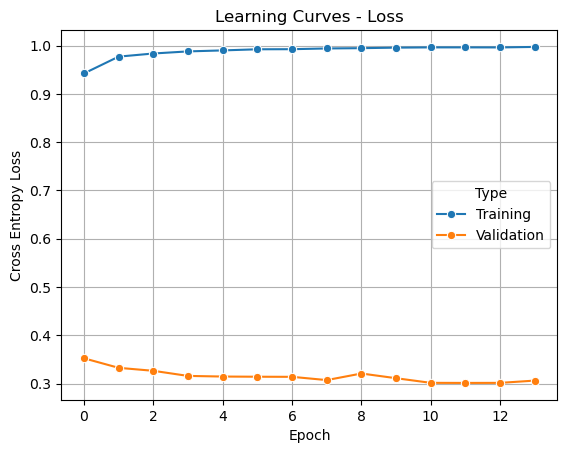

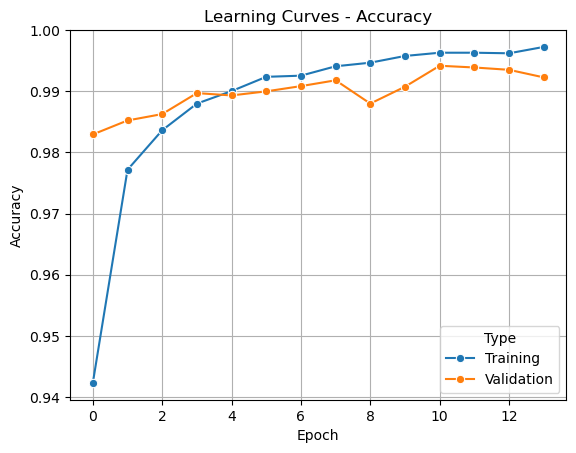

In [ ]:
tasks.results.learning_curves_loss(history)
tasks.results.learning_curves_accuracy(history)

  0%|          | 0/438 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       705
           1       1.00      1.00      1.00       833
           2       0.99      0.99      0.99       736
           3       0.99      1.00      1.00       707
           4       1.00      0.99      0.99       701
           5       0.99      0.99      0.99       647
           6       0.99      0.99      0.99       625
           7       0.99      0.99      0.99       721
           8       0.99      1.00      0.99       667
           9       0.98      0.98      0.98       658

    accuracy                           0.99      7000
   macro avg       0.99      0.99      0.99      7000
weighted avg       0.99      0.99      0.99      7000



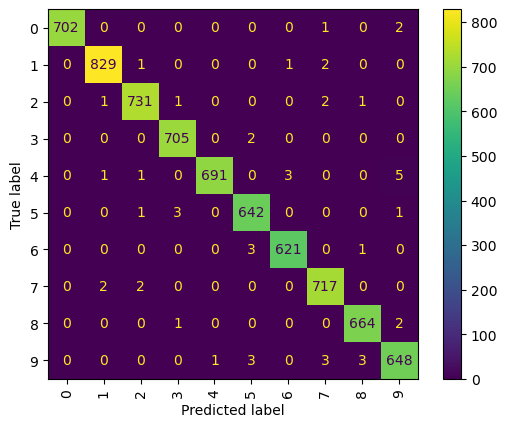

In [ ]:
tasks.results.classification_results(model, ad_source_test_loader, class_names, device)

  0%|          | 0/629 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.92      0.65      0.76      1004
           1       0.63      0.92      0.75      1116
           2       0.75      0.78      0.77      1018
           3       0.67      0.76      0.72      1041
           4       0.89      0.60      0.72       961
           5       0.73      0.79      0.76       912
           6       0.83      0.70      0.76       969
           7       0.80      0.79      0.80      1061
           8       0.83      0.65      0.73       998
           9       0.66      0.79      0.72       983

    accuracy                           0.75     10063
   macro avg       0.77      0.74      0.75     10063
weighted avg       0.77      0.75      0.75     10063



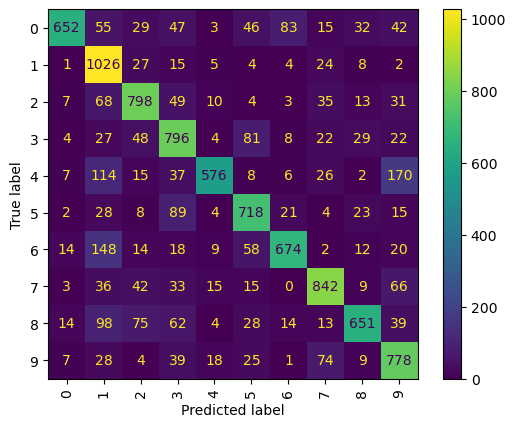

In [ ]:
tasks.results.classification_results(model, ad_target_test_loader, class_names, device)

In [ ]:
model = tasks.utils.get_model(
    device=device, replace_fc_layer=True, num_classes=len(mnist_encodings)
)

if AD_TRAIN_SEMI_SUPERVISED_MODEL_LARGE:
    criterion = nn.CrossEntropyLoss(label_smoothing=0.15)
    # import fine tuned model, not previous unsupervised model
    # we are assuming training takes one go, no intermediate saving here
    model = tasks.utils.try_load_weights(
        model, os.path.join(AD_SEMI_SUPERVISED_FINETUNED_MODEL_DIR_LARGE, "model.pt")
    )
    optimizer_ft = optim.AdamW(model.parameters(), weight_decay=WEIGHT_DECAY)

    source_history = None
    target_history = None
    model, source_history, target_history, label_history = (
        lib.adaptive_train_eval.train_adaptive_model(
            model=model,
            criterion=criterion,
            optimizer=optimizer_ft,
            scheduler=exp_lr_scheduler,
            device=device,
            source_train_dataset=ad_labeled_dataset_large,
            source_val_dataset=ad_source_val_dataset,
            labeled_dataloader_initializer=lambda dataset, sampler=None: tasks.preprocessing.create_padded_dataloader(
                dataset, sampler=sampler, batch_size=BATCH_SIZE
            ),
            # we can not use padding with unlabeled data
            unlabeled_dataloader_initializer=lambda dataset: tasks.preprocessing.single_batch_loader(
                dataset, shuffle=True, n_workers=8
            ),
            unlabeled_target_train_dataset=ad_unlabeled_dataset_large,
            target_val_dataset=ad_target_val_dataset,
            output_dir=AD_SEMI_SUPERVISED_ADAPTIVE_MODEL_DIR_LARGE,
            num_epochs=160,
            pseudo_sample_period=SAMPLING_PERIOD,
            rho=RHO,
            previous_source_history=source_history,
            previous_target_history=target_history,
            verbose=False,
        )
    )
else:
    res = tasks.utils.load_trained_model(
        model, AD_SEMI_SUPERVISED_ADAPTIVE_MODEL_DIR_LARGE
    )
    model = res["model"]
    source_history = res["source_history"]
    target_history = res["target_history"]
    label_history = res["label_history"]

In [ ]:
tasks.results.learning_curves_loss(source_history)
tasks.results.learning_curves_accuracy(source_history)

In [ ]:
tasks.results.learning_curves_loss(target_history)
tasks.results.learning_curves_accuracy(target_history)

In [ ]:
tasks.results.plot_label_history(label_history, mnist_encodings)

In [ ]:
tasks.results.classification_results(model, ad_target_test_loader, class_names, device)

## Exporting the figures

In [ ]:
office_model_dirs = [
        (FINETUNED_SOURCE__MODEL_DIR, "Source"),
        (UNSUPERVISED_MODEL_DIR, "Unsupervised"),
        (SEMI_SUPERVISED_ADAPTIVE_MODEL_DIR_10, "Semi-Supervised 10"),
        (SEMI_SUPERVISED_ADAPTIVE_MODEL_DIR_20, "Semi-Supervised 20")
    ]
office_base_model = tasks.utils.get_model(device)

mnist_model_dirs = [
        (AD_FINETUNED_MODEL_DIR, "Source"),
        (AD_UNSUPERVISED_MODEL_DIR, "Unsupervised"),
        (AD_SEMI_SUPERVISED_ADAPTIVE_MODEL_DIR_SMALL, "Semi-Supervised 10"),
        (AD_SEMI_SUPERVISED_ADAPTIVE_MODEL_DIR_LARGE, "Semi-Supervised 20"),

    ]
mnist_base_model = tasks.utils.get_model(
    device=device, replace_fc_layer=True, num_classes=len(mnist_encodings)
)

In [ ]:
tasks.results.plot_classification_matrices(
    office_base_model,
    office_model_dirs,
    target_test_loader,
    device,
    rows=2,
    cols=2,
    save_path=os.path.join(RESULTS_DIR, "office_cls_matrix.jpeg"),
)

In [ ]:
tasks.results.plot_classification_matrices(
    mnist_base_model,
    mnist_model_dirs[:2],
    ad_target_test_loader,
    device,
    rows=1,
    cols=2,
    save_path=os.path.join(RESULTS_DIR, "mnist_cls_matrix.jpeg"),
)

In [ ]:
tasks.results.plot_label_history_grid(
    mnist_model_dirs[1:],
    mnist_encodings,
    rows=1,
    cols=3,
    figsize=(15, 7),
    save_path=os.path.join(RESULTS_DIR, "mnist_misclassifications.jpeg"),
)

In [ ]:
tasks.results.plot_label_history_grid(
    office_model_dirs[1:],
    office_encodings,
    rows=1,
    cols=3,
    figsize=(15, 7),
    save_path=os.path.join(RESULTS_DIR, "office_misclassifications.jpeg"),
)

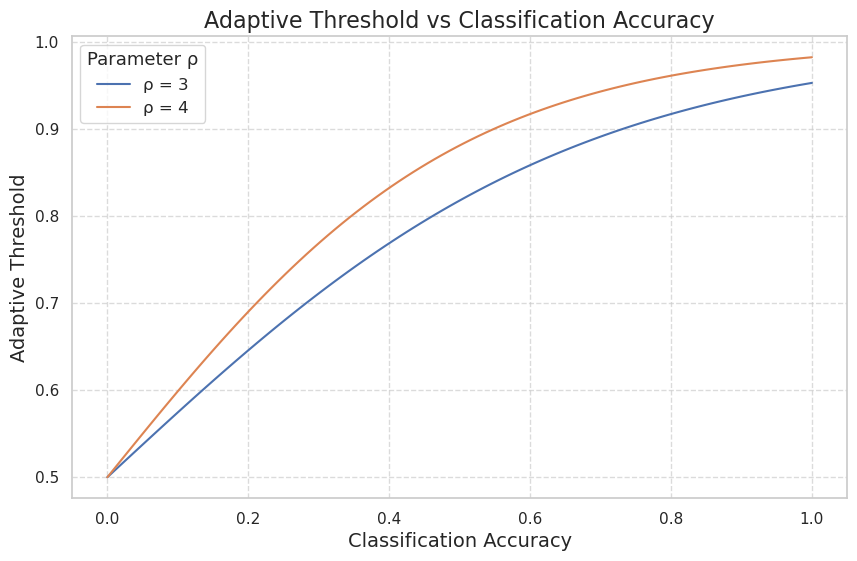

Plot saved in results/adaptive_threshold.jpeg


In [19]:
import seaborn as sns


classification_accuracies = np.linspace(0, 1, 100)
path = os.path.join(RESULTS_DIR, "adaptive_threshold.jpeg")

sns.set_theme(style="whitegrid")
plt.figure(figsize=(10, 6))


for rho in [3, 4]:
    thresholds = [lib.adaptive_train_eval.adaptive_threshold(acc, rho) for acc in classification_accuracies]
    
    sns.lineplot(x=classification_accuracies, y=thresholds, label=f'ρ = {rho}')

plt.xlabel('Classification Accuracy', fontsize=14)
plt.ylabel('Adaptive Threshold', fontsize=14)
plt.title('Adaptive Threshold vs Classification Accuracy', fontsize=16)
plt.legend(title='Parameter ρ', title_fontsize='13', fontsize='12')
plt.grid(True, linestyle='--', alpha=0.7)

plt.savefig(path)
plt.show()

print(f"Plot saved in {path}")